<h1><center>Robustness - Adult Income Dataset</center></h1>

In [3]:
# Importing external library

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation

## Preprocessing

In [5]:
# Importing the dataset
dataset = pd.read_csv('adultdata.csv', delimiter = ",",header= None)
X = dataset.iloc[:,0:13]
y = np.asarray(dataset.iloc[:,14])

# Filling the missing values by most occuring value(mode) of respective column.
X = X.fillna(X.mode().iloc[0])

# Label Encoding the cloumns from string values to int values
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
for i in [1,3,5,6,7,8,9]:
    X.iloc[:,i] = le.fit_transform(X.iloc[:,i])

# Standarsize large values   
sc = StandardScaler()
X.iloc[:,[2,10,11]] = sc.fit_transform(X.iloc[:,[2,10,11]]) 

# Dropping the redundant data column
X = X.drop(X.columns[3], axis =1)   

# Transforming data to normal distribution
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X = quantile_transformer.fit_transform(X)

In [6]:
print('Data size:', X.shape)
print('Class 1:', X[y==0].shape[0])
print('Class 2:', X[y==1].shape[0])

Data size: (32561, 12)
Class 1: 24720
Class 2: 7841


## Helper methods

In [7]:
def fit_evaluate_supervised(model, X_train, y_train, X_test, y_test):
    """Fits model and returns f_score on test data"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

def fit_evaluate_unsupervised(model, X_train, X_test, y_test):
    model.fit(X_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

def reduce_data(X, y, reduction_perc):
    """Reduces the class 1 by reduction_perc"""
    ok = X[y == 0]
    nok = X[y == 1]

    row_i = np.random.choice(nok.shape[0], int(len(nok)*(1-reduction_perc)))
    nok = nok[row_i,:]

    X_reduced = np.concatenate((ok, nok))
    y_reduced = np.array([0]*len(ok) + [1]*len(nok))

    return shuffle(X_reduced, y_reduced)

def pick(results, train_ratio=None, reduction_train=None, reduction_test=None, model=None):
    tmp = results
    if(train_ratio != None):
        tmp = tmp[(tmp.index.get_level_values('train_ratio') == train_ratio)]
    if(reduction_train != None):
        tmp = tmp[(tmp.index.get_level_values('reduction_train') == reduction_train)]
    if(reduction_test != None):
        tmp = tmp[(tmp.index.get_level_values('reduction_test') == reduction_test)]
    if(model != None):
        tmp = tmp.loc[model]
    return tmp

## Supervised models

In [14]:
dfs_supervised = []
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]

for train_ratio in [0.5, 0.75, 0.9]:
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio)

    for reduction_train in percentages:
        #Reduce train data
        X_train_reduced, y_train_reduced = reduce_data(X_train, y_train, reduction_train)

        #Oversample to balance the two classes
        sm = RandomOverSampler(random_state=42)
        X_train_reduced, y_train_reduced = sm.fit_resample(X_train_reduced, y_train_reduced)

        for reduction_test in percentages:
            #Reduce test data
            X_test_reduced, y_test_reduced = reduce_data(X_test, y_test, reduction_test)

            #Models
            lr = LogisticRegression()
            rf = RandomForestClassifier()
            knn = KNeighborsClassifier()
            gaussian = GaussianNB()
            perceptron = Perceptron()
            linear_svc = LinearSVC()
            sgd = SGDClassifier()
            decision_tree = DecisionTreeClassifier()

            #Compute F_Score for each model
            for model in [lr, rf, knn, gaussian, perceptron, linear_svc, sgd, decision_tree]:
                results = [('model',  type(model).__name__),
                           ('train_ratio',  train_ratio),
                           ('reduction_train', reduction_train), 
                           ('reduction_test', reduction_test),
                           ('f_score',  fit_evaluate_supervised(model, X_train_reduced, y_train_reduced,
                                                     X_test_reduced, y_test_reduced))]

                #Create DataFrame to store the results
                dfs_supervised.append(pd.DataFrame({x[0]:x[1:] for x in results}))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

In [15]:
#Concatenate results
results_supervised = pd.concat(dfs_supervised)

#Group by reeduction percentages (train & test)
results_supervised_grouped = results_supervised.groupby(['model', 'train_ratio', 'reduction_train', 'reduction_test']).agg(np.mean)

## Plot F-Scores

In [16]:
pick(results_supervised_grouped, train_ratio=0.5, reduction_train=0.0).head()

f_score
model                  train_ratio reduction_train reduction_test          
DecisionTreeClassifier 0.5         0.0             0.00            0.595822
                                                   0.25            0.575391
                                                   0.50            0.510783
                                                   0.75            0.408886
                                                   0.99            0.031561

<h3 style='color:red'>No reduction in Train</h3>

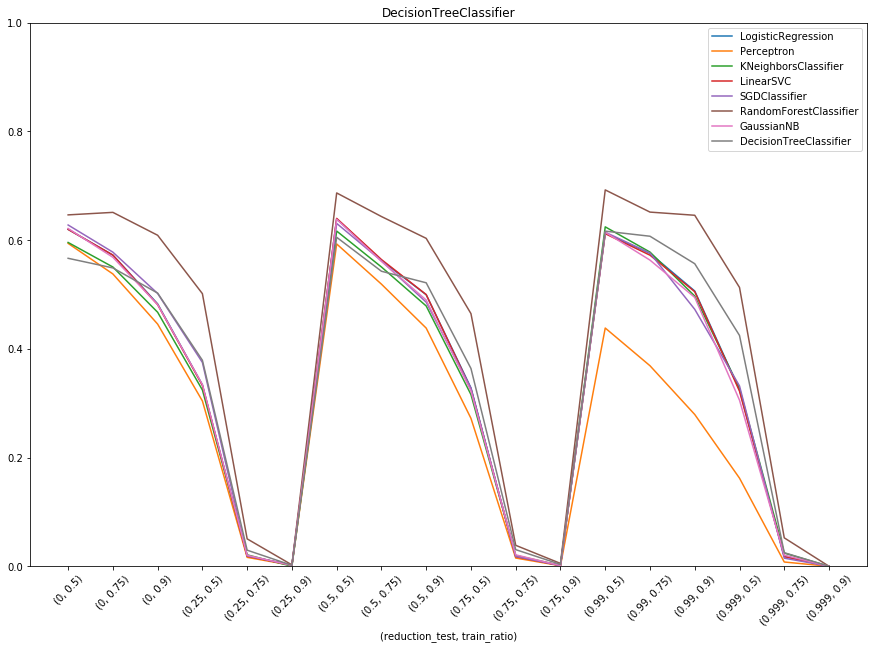

In [486]:
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]
train_ratios = [0.5,0.75,0.9]

xticks = [str((x, y)) for x in percentages for y in train_ratios]
fig, ax = plt.subplots(figsize=(15, 10))

for model in set(results_supervised.model):
    pick(results_supervised_grouped, reduction_train=0.0, model=model).plot(ax=ax)
    _ = plt.ylim(0, 1)
    _ = plt.xticks(range(len(xticks)),xticks, rotation=46)
    _ = plt.title(model)
    
ax.legend(set(results_supervised.model))
_ = plt.xlabel('(reduction_test, train_ratio)')

<h3 style='color:red'>No reduction in Test</h3>

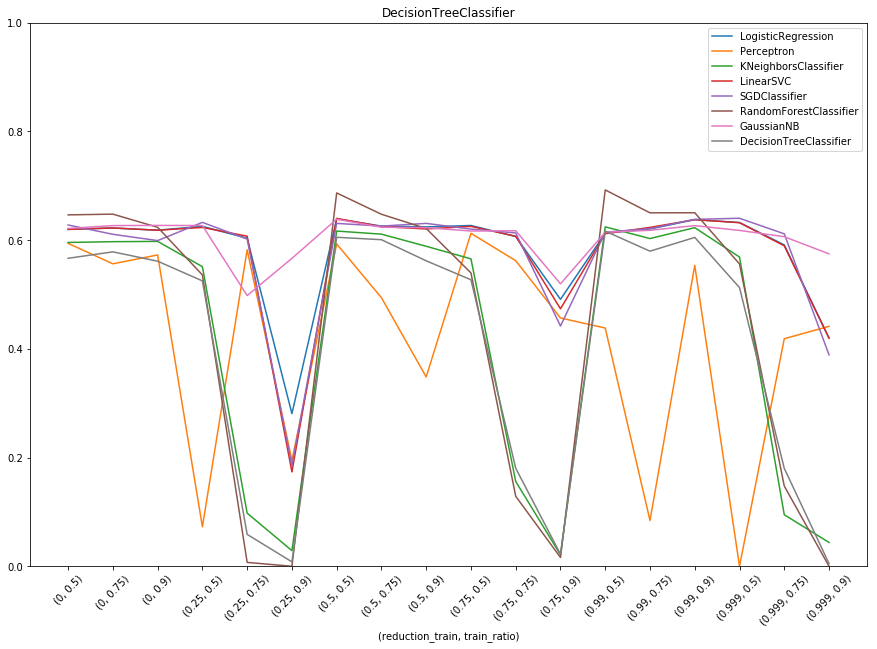

In [487]:
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]
train_ratios = [0.5,0.75,0.9]

xticks = [str((x, y)) for x in percentages for y in train_ratios]
fig, ax = plt.subplots(figsize=(15, 10))

for model in set(results_supervised.model):
    pick(results_supervised_grouped, reduction_test=0.0, model=model).plot(ax=ax)
    _ = plt.ylim(0, 1)
    _ = plt.xticks(range(len(xticks)),xticks, rotation=46)
    _ = plt.title(model)
    
ax.legend(set(results_supervised.model))
_ = plt.xlabel('(reduction_train, train_ratio)')

## Unsupervised models

In [17]:
dfs_unsupervised = []
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]

for train_ratio in [0.5, 0.75, 0.9]:
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio)

    for reduction_train in percentages:

        #Reduce training data
        X_train_reduced, y_train_reduced = reduce_data(X_train, y_train, reduction_train)

        for reduction_test in percentages:
            #Reduce testing data
            X_test_reduced, y_test_reduced = reduce_data(X_test, y_test, reduction_test)  

            #Models
            kmeans = KMeans(2)
            iso_forest = IsolationForest()
            lof = LocalOutlierFactor(novelty=True)
            gmm = GaussianMixture()
            
            #Compute F_Scores
            for model in [iso_forest, kmeans, lof, gmm]:
                if(type(model).__name__ in ['KMeans', 'GaussianMixture']):
                    f_score = fit_evaluate_unsupervised(kmeans, X_train_reduced, X_test_reduced, y_test_reduced)
                else:
                    model.fit(X_train)
                    y_pred = (model.predict(X_test) < 0).astype(int)
                    f_score = f1_score(y_test, y_pred)

                results = [('model',  type(model).__name__), 
                           ('train_ratio', train_ratio),
                           ('reduction_train', reduction_train), 
                           ('reduction_test', reduction_test), 
                           ('f_score', f_score)]

                #Store results in DataFrame
                dfs_unsupervised.append(pd.DataFrame({x[0]:x[1:] for x in results}))

In [18]:
results_unsupervised = pd.concat(dfs_unsupervised)
results_unsupervised_grouped = results_unsupervised.groupby(['model', 'train_ratio','reduction_train', 'reduction_test']).agg(np.mean)

<h3 style='color:red'>No reduction in Train</h3>

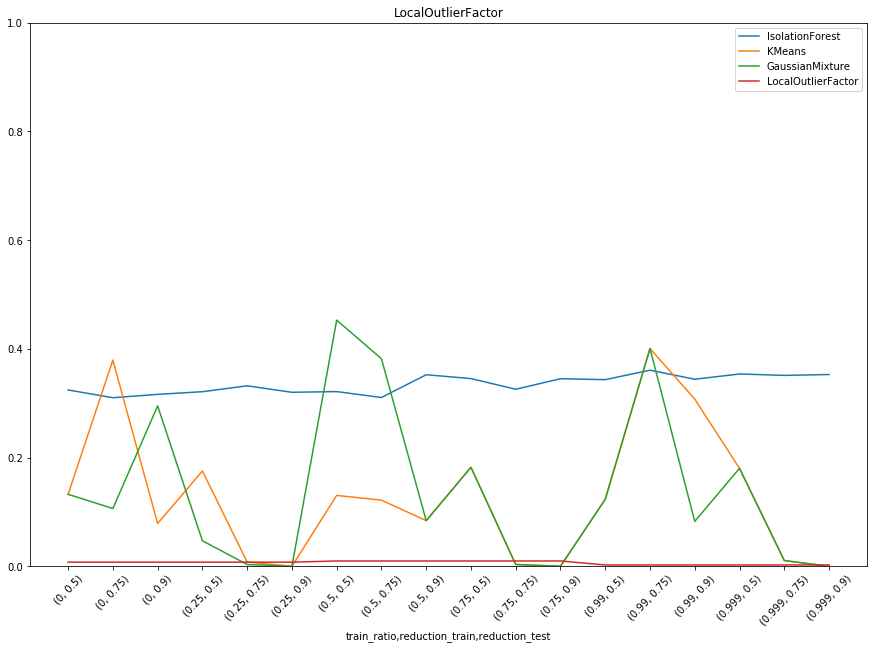

In [462]:
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]
train_ratios = [0.5,0.75,0.9]

xticks = [str((x, y)) for x in percentages for y in train_ratios]
fig, ax = plt.subplots(figsize=(15, 10))

for model in set(results_unsupervised.model):
    pick(results_unsupervised_grouped, reduction_train=0.0, model=model).plot(ax=ax)
    _ = plt.ylim(0, 1)
    _ = plt.xticks(range(len(xticks)),xticks, rotation=46)
    _ = plt.title(model)
    
ax.legend(set(results_unsupervised.model))

<h3 style='color:red'>No reduction in Train</h3>

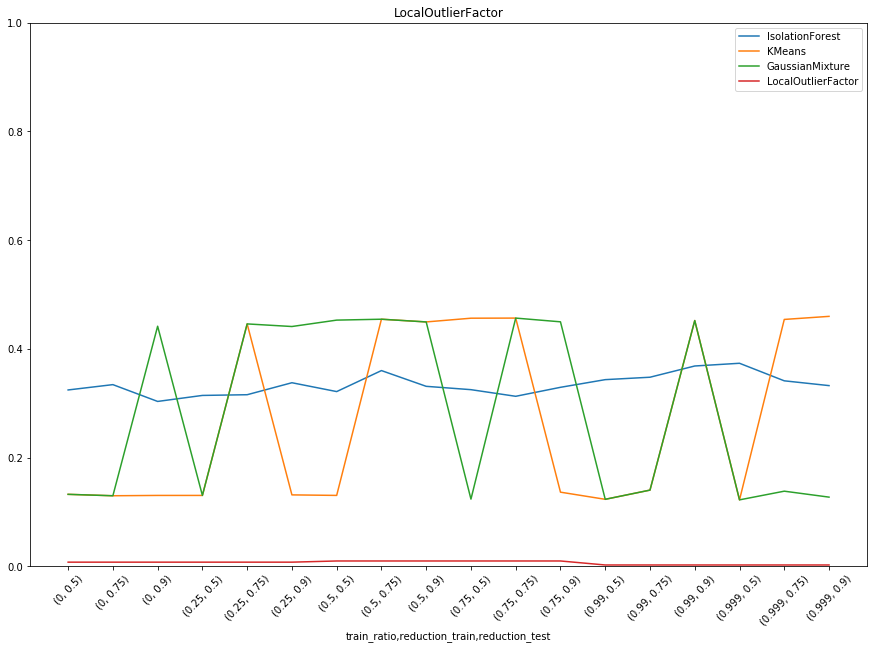

In [484]:
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]
train_ratios = [0.5,0.75,0.9]

xticks = [str((x, y)) for x in percentages for y in train_ratios]
fig, ax = plt.subplots(figsize=(15, 10))

for model in set(results_unsupervised.model):
    pick(results_unsupervised_grouped, reduction_test=0.0, model=model).plot(ax=ax)
    _ = plt.ylim(0, 1)
    _ = plt.xticks(range(len(xticks)),xticks, rotation=46)
    _ = plt.title(model)
    
ax.legend(set(results_unsupervised.model))

## Random

In [38]:
#dfs_random = []
percentages = [0, 0.25, 0.5, 0.75, 0.99, 0.999]

for train_ratio in [0.5, 0.75, 0.9]:
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio)

    for reduction_train in percentages:

        #Reduce training data
        X_train_reduced, y_train_reduced = reduce_data(X_train, y_train, reduction_train)

        for reduction_test in percentages:
            #Reduce testing data
            X_test_reduced, y_test_reduced = reduce_data(X_test, y_test, reduction_test)  

            anomaly_perc = 0.5 #sum(y_train)/len(y_train)
            y_pred = np.random.choice([0, 1], size=(len(y_test),), p=[1-anomaly_perc, anomaly_perc])
        
            f_score = f1_score(y_test, y_pred)

            results = [('model',  'random_half_half'), 
                       ('train_ratio', train_ratio),
                       ('reduction_train', reduction_train), 
                       ('reduction_test', reduction_test), 
                       ('f_score', f_score)]

            #Store results in DataFrame
            dfs_random.append(pd.DataFrame({x[0]:x[1:] for x in results}))

In [51]:
results_random = pd.concat(dfs_random)
results_random_grouped = results_random.groupby(['model', 'train_ratio','reduction_train', 'reduction_test']).agg(np.mean)

## Robustness

In [45]:
def compute_lip(model, results, lipschitz, train_ratio, reduction_train=None, reduction_test=None):
    #test_f1 = results[results.model.str.contains(model)].groupby(['reduction_train']).agg(np.mean)['f_score'].values
    test_f1 = pick(results, train_ratio=train_ratio, reduction_train=reduction_train,  reduction_test=reduction_test, model=model).values
    final_results = []
    for i in range(len(test_f1)):
        elem_i = test_f1[i]
        for j in range(i+1, len(test_f1)):
            elem_j = test_f1[j]
            if(lipschitz):
                lipschitz_cte_estimator = (abs(elem_j-elem_i)/abs(j-i))
                final_results.append((j-i, lipschitz_cte_estimator))
            else:
                final_results.append(((j-i), (elem_j-elem_i)**2))
    final_results.sort(key=lambda tup: tup[0])  # sorts in place
    return final_results, np.mean([x[1] for x in final_results])
    
def plot_distance_performance(model,l, ax, marker):
    d = defaultdict(list)
    distance_performance = []
    for key, value in l:
        d[key].append(value)

    for key in d:
        distance_performance.append((key, np.mean(d[key])))

    ax.scatter(*zip(*distance_performance), label=model, marker=marker, s=50, alpha=0.8)

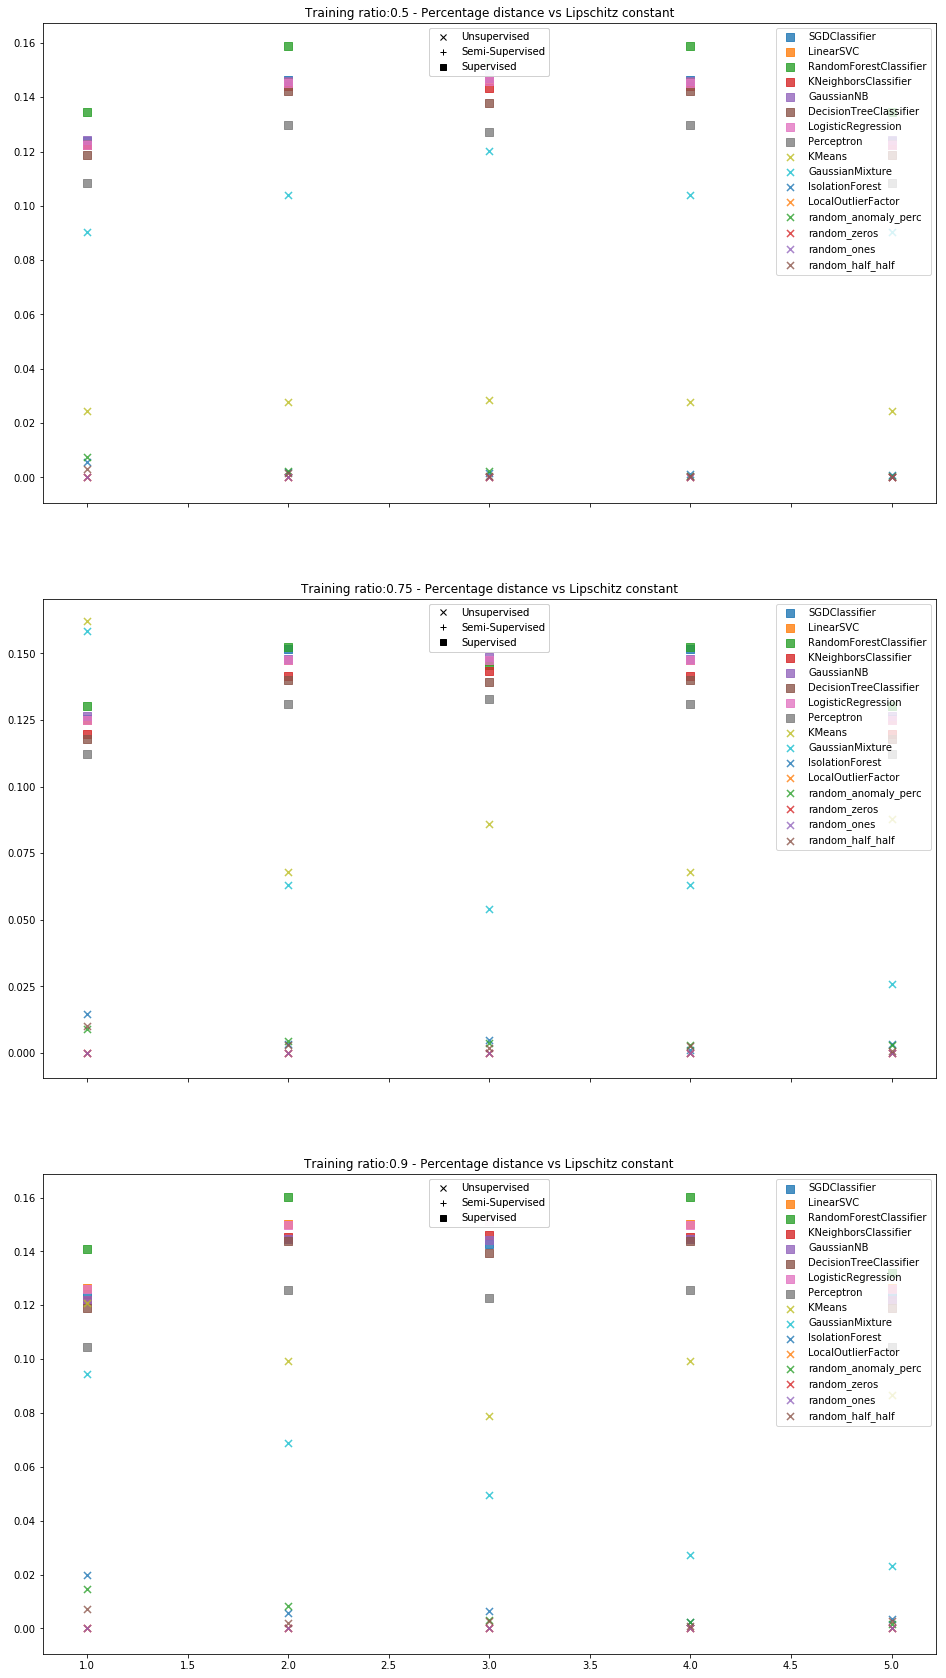

In [52]:
from matplotlib.lines import Line2D

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(16, 30))

reduction_train= 0
#reduction_test = 0

lipschitz = True
training_ratios = [0.5, 0.75, 0.9]
lipschitz_per_model = []

for ax, training_ratio in zip([ax1, ax2, ax3], training_ratios):        
    for model in set(results_supervised.model):
        l, mean_lip = compute_lip(model, results_supervised_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model, training_ratio, mean_lip))
        plot_distance_performance(model, l, ax, 's')
        
    for model in set(results_unsupervised.model):
        l, mean_lip = compute_lip(model, results_unsupervised_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model,training_ratio, mean_lip))
        plot_distance_performance(model, l, ax, 'x')
        
    for model in random_models:
        l, mean_lip = compute_lip(model, results_random_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model,training_ratio, mean_lip))
        plot_distance_performance(model, l, ax, 'x')

    if(lipschitz):
        ax.set_title('Training ratio:'+ str(training_ratio) + ' - Percentage distance vs Lipschitz constant')
    else:
        ax.set_title('Training ratio:'+ str(training_ratio) + '- Percentage distance vs Difference Performance Squared')
    legend1 = ax.legend(loc=1)
    legend_elements = [Line2D([], [], marker='x', color='black', linestyle='None', label='Unsupervised'),
                       Line2D([], [], marker='+', color='black', linestyle='None', label='Semi-Supervised'),
                       Line2D([], [], marker='s',color='black', linestyle='None', label='Supervised')]
    
    legend2 = ax.legend(handles=legend_elements, loc=9) 
    ax.add_artist(legend1)
    ax.add_artist(legend2)


### Average robustness per model

In [48]:
unsupervised_models = set(results_unsupervised.model)
supervised_models = set(results_supervised.model)
random_models = set([x for x in results_random.model])

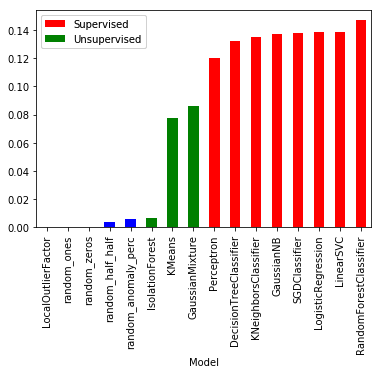

In [53]:
from matplotlib.patches import Patch

robustness_df = pd.DataFrame(lipschitz_per_model, columns=['Model', 'train_ratio', 'lipschitz'])
robutness_df_grouped = robustness_df.groupby(['Model']).agg(np.mean)['lipschitz'].sort_values()

fig, ax = plt.subplots()

color_code = ['r' if x in supervised_models else 'g' if x in unsupervised_models else 'b' for x in robutness_df_grouped.index]
_ = robutness_df_grouped.plot.bar(color=color_code)

legend_elements = [Patch(facecolor='r',label='Supervised'),
                   Patch(facecolor='g',label='Unsupervised')]
legend = ax.legend(handles=legend_elements, loc=2)
ax.add_artist(legend)

**==> Unsupervised methods are more robust to changes in the data**

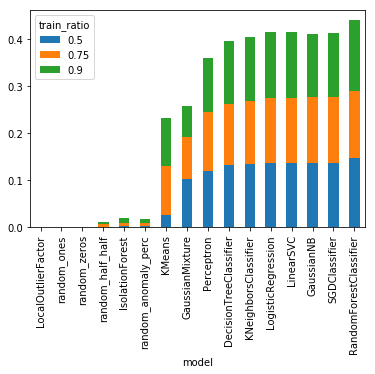

In [54]:
lip_df = pd.DataFrame(lipschitz_per_model, columns=['model', 'train_ratio', 'Lipschitz_constant'])
lip_df.pivot(index='model', columns='train_ratio', values='Lipschitz_constant').sort_values(by=0.5).plot(kind='bar', stacked=True)

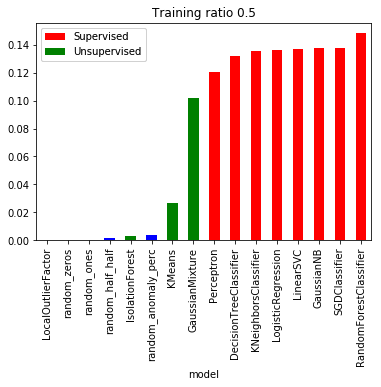

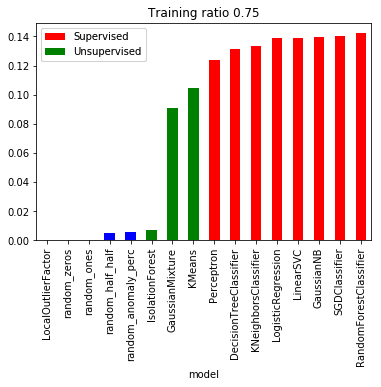

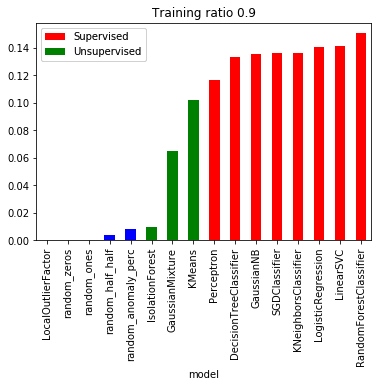

In [57]:
for train_ratio in [0.5, 0.75, 0.9]:
    fig, ax = plt.subplots()
    sorted_lip = lip_df[lip_df.train_ratio == train_ratio].set_index('model')['Lipschitz_constant'].sort_values()
    color_code = ['r' if x in supervised_models else 'g' if x in unsupervised_models else 'b' for x in sorted_lip.index]
    sorted_lip.plot(kind='bar', color=color_code)
    plt.title('Training ratio ' + str(train_ratio))
    
    legend_elements = [Patch(facecolor='r',label='Supervised'),
                   Patch(facecolor='g',label='Unsupervised')]
    legend = ax.legend(handles=legend_elements, loc=2)
    ax.add_artist(legend)

In [56]:
results = pd.concat([results_supervised, results_unsupervised])

In [614]:
f_score_robustness = results.groupby(['model', 'train_ratio']).agg(np.mean)[['f_score']]
f_score_robustness['robustness'] =  lip_df.groupby(['model', 'train_ratio']).agg(np.mean)['Lipschitz_constant']
f_score_robustness.sort_values(['f_score', 'robustness'], ascending=[False, False]).head()

In [626]:
f_score_robustness['score'] = 2*(f_score_robustness['f_score']*(-f_score_robustness['robustness']))/(f_score_robustness['f_score']-f_score_robustness['robustness'])
f_score_robustness.sort_values(by='score', ascending=False).head()